# Topographic correction of UAV albedo measurements

This notebook provides a walkthrough of the topographic correction of UAV albedo measurements and subsequent comparison to an external distributed albedo product, which in this case is Landsat 8.

In [252]:
import pandas as pd
import numpy as np
from osgeo import gdal, gdalconst
import math
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import seaborn as sns

Let's first define the required parameters

In [253]:
# Fields derived from UAV GPS 
point_lon = 462657.480292 #UTM Zone 12N
point_lat = 5008796.512674 #UTM Zone 12N
point_alt_msl = 2694.050167
agl_alt = 50

#Fields derived from UAV inertial measurement unit (IMU)
tilt = 2.150056
tilt_dir = 269.444897
tilt_radians = np.radians(tilt)
tilt_dir_radians = np.radians(tilt_dir)

pitch = 0
roll = 10
yaw = -90
pitch_radians = np.radians(pitch)
roll_radians = np.radians(roll)
yaw_radians = np.radians(yaw)

#define processing field of view (PFOV) for footprint projection
PFOV = 140
PFOV_rad = np.radians(PFOV)

#uncorrected albedo from pyranometers
uncorrected_albedo = 0.73028

#fields from 6s radiative transfer model, used in topographic correction
solar_zenith = 36
solar_azimuth = 141
solar_zenith_radians = np.radians(solar_zenith)
solar_azimuth_radians = np.radians(solar_azimuth)
p_diffuse = 0.67
p_direct = 0.33

Next we will open the raster data. For the rest of the program to work properly, all data must be in the same UTM coordinate system and have the same geotransform (pixel size and raster extent).

In [254]:
# paths to raster data

# elevation
elev_path = 'D:/UAV-albedo/data_test_dir/03_UAV_snow_data/02_processed_data/03_topo_correction/01_surface_data/3DEP/elevation/YC_3DEP_TC_DEM.tif'

# slope (decimal degrees)
slope_path = 'D:/UAV-albedo/data_test_dir/03_UAV_snow_data/02_processed_data/03_topo_correction/01_surface_data/3DEP/slope/YC_3DEP_TC_slope.tif'

# aspect (decimal degrees ranging form 0-360)
aspect_path = 'D:/UAV-albedo/data_test_dir/03_UAV_snow_data/02_processed_data/03_topo_correction/01_surface_data/3DEP/aspect/YC_3DEP_TC_aspect.tif'

# raster grids containing the longitude (x) and latitude (y) UTM coordinate for each pixel
xcoords_path = 'D:/UAV-albedo/data_test_dir/03_UAV_snow_data/02_processed_data/03_topo_correction/01_surface_data/3DEP/coordinates/YC_3DEP_TC_xcoords.tif'
ycoords_path = 'D:/UAV-albedo/data_test_dir/03_UAV_snow_data/02_processed_data/03_topo_correction/01_surface_data/3DEP/coordinates/YC_3DEP_TC_ycoords.tif'

# external gridded albedo product used for comparison to UAV data, in this case it is Landsat 8 (LS8)
ls8_path = 'D:/UAV-albedo/data_test_dir/03_UAV_snow_data/02_processed_data/03_topo_correction/01_surface_data/3DEP/LS8/20210428_YC_LS8_3DEP.tif'

# open models using gdal
elev = gdal.Open(elev_path, gdalconst.GA_ReadOnly)
slope = gdal.Open(slope_path, gdalconst.GA_ReadOnly)
aspect = gdal.Open(aspect_path, gdalconst.GA_ReadOnly)
xcoords = gdal.Open(xcoords_path, gdalconst.GA_ReadOnly)
ycoords = gdal.Open(ycoords_path, gdalconst.GA_ReadOnly)
ls8 = gdal.Open(ls8_path, gdalconst.GA_ReadOnly)

# get bands as numpy arrays
# for the elevation raster we need to open the assign the raster band object to a variable for input into the viewshed algorithm
elev_band = elev.GetRasterBand(1)
elev_array = elev_band.ReadAsArray()

slope_array = slope.GetRasterBand(1).ReadAsArray()

aspect_array = aspect.GetRasterBand(1).ReadAsArray()

xcoords_array = xcoords.GetRasterBand(1).ReadAsArray()

ycoords_array = ycoords.GetRasterBand(1).ReadAsArray()

ls8_array = ls8.GetRasterBand(1).ReadAsArray()

## Footprint projection
In order to calculate the terrain parameters used in the topographic correction for a single measurement point we need to project the downward-facing sensor footprint onto the ground based on the defined processing field of view (PFOV). This footprint projection will also be used to aggregate the pixels from the external albedo product for comparison. This requires a few steps. First, we run a regular viewshed algorithm to take care of terrain blockage. Next, we calculate the angle between the sensor and each pixel on the ground. If the angle exceeds half the PFOV, the pixel is outside the footprint and is set to nan.

![image](img/Processing_vs_Sensor_FOV.png)

In [255]:
viewshed = gdal.ViewshedGenerate(elev_band, 'GTiff', 
                                 'D:/UAV-albedo/data_test_dir/temp_files/temp_viewshed.tif',
                                 creationOptions=None,
                                 observerX=point_lon, 
                                 observerY=point_lat, 
                                 observerHeight = agl_alt, 
                                 targetHeight = 0,
                                 visibleVal=1,
                                 invisibleVal=0,
                                 outOfRangeVal=0,
                                 noDataVal=np.nan,
                                 dfCurvCoeff=1,
                                 mode=1,
                                 maxDistance=1000)

The viewshed raster saves to a temporary file. This temporary file needs to be resampled to match the size of the rest of the raster data.

In [256]:
original_proj = viewshed.GetProjection()

desired_gt = elev.GetGeoTransform()
desired_proj = elev.GetProjection()
desired_cols = elev.RasterXSize
desired_rows = elev.RasterYSize
    
minX = desired_gt[0]
maxX = desired_gt[0] + (desired_cols * desired_gt[1])
    
minY = desired_gt[3] + (desired_rows * desired_gt[5])
maxY = desired_gt[3]

warp_options = gdal.WarpOptions(format = 'GTiff', 
                          outputBounds = [minX, minY, maxX, maxY], 
                          width = desired_cols, height = desired_rows,
                          srcSRS = original_proj, dstSRS = desired_proj)
    
viewshed_resampled = gdal.Warp('D:/UAV-albedo/data_test_dir/temp_files/temp_viewshed_res.tif', viewshed, options = warp_options)

viewshed_array = viewshed_resampled.GetRasterBand(1).ReadAsArray()

For whatever reason, the viewshed algorithm sets the pixel directly beneath the observation point to invisible, so we need to find this pixel and set it to 1 (visible).

In [257]:
def get_point_index(point_lon, point_lat, xcoords_array, ycoords_array):
        
        xcoord_dif = np.abs(np.subtract(xcoords_array[0], point_lon))
        ycoord_dif = np.abs(np.subtract(ycoords_array[:,0], point_lat))
        
        x_index = np.where(xcoord_dif == np.nanmin(xcoord_dif))[0][0]
        y_index = np.where(ycoord_dif == np.nanmin(ycoord_dif))[0][0]
        
        return y_index, x_index

In [258]:
y_index, x_index = get_point_index(point_lon, point_lat, xcoords_array, ycoords_array)
viewshed_array[y_index+1, x_index] = 1

Now let's plot the viewshed raster next to the elevation raster. Visible portions will be displayed in yellow.

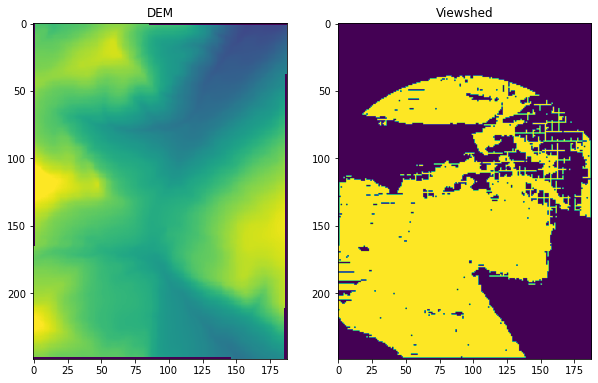

In [259]:
plt.rcParams["figure.figsize"] = (10,10)

f, axes = plt.subplots(1,2)
axes[0].imshow(elev_array,vmin=2400, vmax=2800)
axes[1].imshow(viewshed_array,vmin=0, vmax=1)

axes[0].title.set_text('DEM')
axes[1].title.set_text('Viewshed')

Next, we will improve upon this viewshed by projecting the sensing footprint onto the ground, and masking out all pixels that do not lie within the footprint. First, we will define a function that rotates the normal vector of the downward-facing pyranometer based on the pitch, roll, and yaw of the platform.

In [260]:
def rotate_normals(surface_normal, pitch_rad, roll_rad, yaw_rad):
    
    r = R.from_euler('ZYX', [yaw_rad, pitch_rad, roll_rad], degrees=False)
    
    return r.apply(surface_normal)

However, the yaw of the UAV is in azimuthal degrees from north and the rotation takes place in a cartesian coordinate system. Therefore we need to convert yaw to cartesian rotation around the Z axis. We also need to reverse the direction of rotation of pitch due to differences between the UAV and cartesian coordinate systems.

In [261]:
pitch_radians = np.radians(pitch*-1)
roll_radians = np.radians(roll)
yaw_radians = np.radians(90-yaw)

#set elevation raster pixels to nan if outside viewshed
not_visible = np.where(viewshed_array==0)
        
elev_array[not_visible] = np.nan
    
#calculate necesarry distance arrays for footprint projection
elev_diff = point_alt_msl - elev_array # calculate elevation difference
elev_diff[elev_diff<=0]=np.nan # points above the downward-facing sensor should be masked out as well
dist_y = ycoords_array - point_lat
dist_x = xcoords_array - point_lon
        
#rotate the surface normal of the downward-facing sensor based off UAV pitch, roll, yaw
surface_normal = [0,0,-1]

surface_normal = rotate_normals(surface_normal, pitch_radians, roll_radians, yaw_radians)
        
#calculate incidence angle between radiating pixel and sensor
angle = np.arcsin(np.abs((surface_normal[0] * dist_x + 
                            surface_normal[1] * dist_y + 
                            surface_normal[2] * -1 * elev_diff) /
                            (np.sqrt(np.square(dist_x)+np.square(dist_y)+np.square(elev_diff)) *
                            np.sqrt(np.square(surface_normal[0])+np.square(surface_normal[1])+np.square(surface_normal[2])
                                    ))
                            ))
        
#now filter pixels based on defined PFOV of sensor
angle[angle<=(math.pi/2)-(PFOV_rad/2)]=np.nan

        
  

C:\Users\x51b783\AppData\Local\Temp/ipykernel_29284/3497531095.py:12: RuntimeWarning: invalid value encountered in less_equal
  elev_diff[elev_diff<=0]=np.nan # points above the downward-facing sensor should be masked out as well
C:\Users\x51b783\AppData\Local\Temp/ipykernel_29284/3497531095.py:31: RuntimeWarning: invalid value encountered in less_equal
  angle[angle<=(math.pi/2)-(PFOV_rad/2)]=np.nan


No we can visualize the rotation of the vector normal to the downward sensor based on pitch, roll, and yaw of the platform

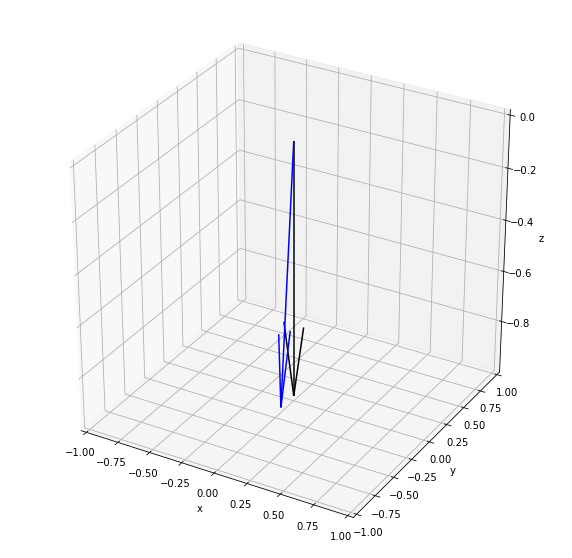

In [262]:
plane_normal = np.array([[0, 0, 0, 0, 0, surface_normal[2]]])
tilted_normal = np.array([[0,0,0, surface_normal[0], surface_normal[1], surface_normal[2]]])

X, Y, Z, U, V, W = zip(*plane_normal)
Xi, Yi, Zi, Ui, Vi, Wi = zip(*tilted_normal)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, color = 'black')
ax.quiver(Xi, Yi, Zi, Ui, Vi, Wi, color = 'blue')


ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
ax.set_zlim(surface_normal[2],0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


plt.show()

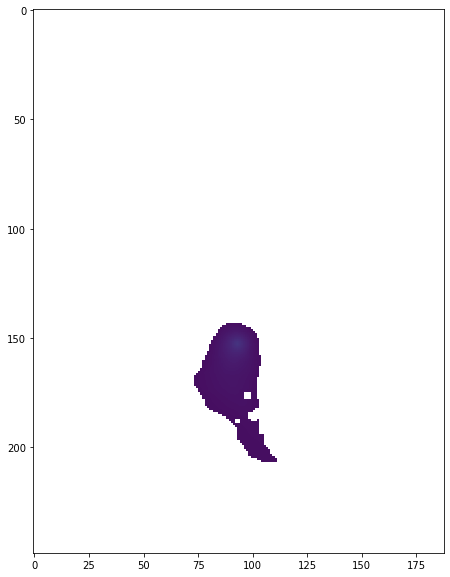

In [263]:
#plt.imshow(angle[120:175, 50:125],vmin=0, vmax=10)
plt.imshow(angle,vmin=0, vmax=10)

Next, we can assign a weighting factor to each pixel based on the incidence angle between the downard sensor and pixel.

In [264]:
#calculate weighting
cosine_incidence = np.cos((math.pi/2)-angle)
cos_sum = np.nansum(cosine_incidence)
weighting = cosine_incidence/cos_sum

In [265]:
def calc_weighted_avg(array, weighting):
    
    return np.nansum(weighting * array)

In [266]:
# calculate cosine wighted average of surface data
weighted_aspect = calc_weighted_avg(aspect_array, weighting)
weighted_slope = calc_weighted_avg(slope_array, weighting)
weighted_ls8 = calc_weighted_avg(ls8_array, weighting)

weighted_aspect_radians = np.radians(weighted_aspect)
weighted_slope_radians = np.radians(weighted_slope)


## Topographic Correction
The next set of calculations topographically corrects the UAV data. We will first calculate the cosine of the incidence angle of the direct solar beam on the upward facing pyranometer and ground surface.

In [267]:
cos_pyranometer_incidence = (math.sin(solar_zenith_radians) * math.sin(tilt_radians) * math.cos(solar_azimuth_radians-tilt_dir_radians) +
             math.cos(solar_zenith_radians) * math.cos(tilt_radians))

cos_slope_incidence = (math.sin(solar_zenith_radians) * math.sin(weighted_slope_radians) * math.cos(solar_azimuth_radians-weighted_aspect) +
             math.cos(solar_zenith_radians) * math.cos(weighted_slope_radians))  

Now we can topographically correct the UAV albedo measurements

In [268]:
corrected_albedo = uncorrected_albedo * ((p_diffuse * np.cos(solar_zenith_radians) + p_direct * cos_pyranometer_incidence) / 
                                           (p_diffuse * np.cos(solar_zenith_radians) + p_direct * cos_slope_incidence))


Now let's compare uncorrected UAV albedo to corrected UAV albedo and LS8 albedo

In [270]:
print('uncorrected albedo: ' + str(uncorrected_albedo))
print('corrected albedo: ' + str(corrected_albedo))
print('LS8 albedo: ' + str(weighted_ls8))

uncorrected albedo: 0.73028
corrected albedo: 0.7279637535952889
LS8 albedo: 0.5179117
